# 模型推理


🔍 自選擇圖片：captcha_0001.png


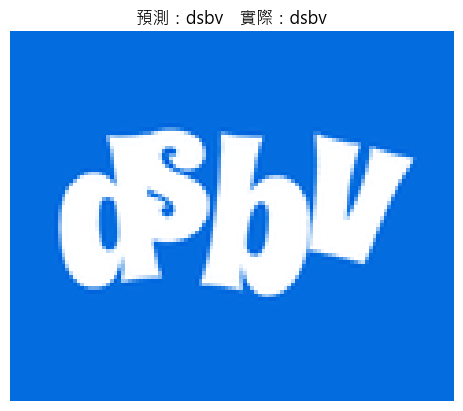

🔍 隨機選擇圖片：captcha_2129.png


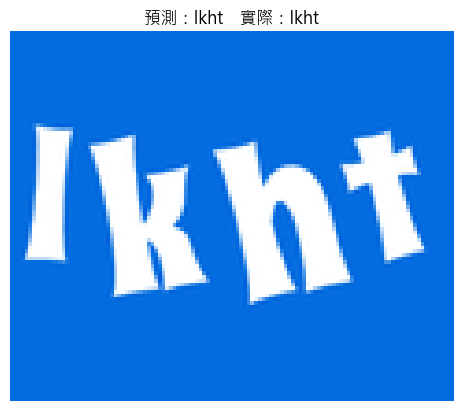

In [8]:
import sys
import csv
from pathlib import Path

import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.pyplot as plt
import random

# 設定 matplotlib 使用支援中文的字型
plt.rcParams["font.family"] = "Microsoft JhengHei"
plt.rcParams["axes.unicode_minus"] = False

# 加入專案根目錄到 import 路徑中
BASE_DIR = Path("..").resolve()
sys.path.append(str(BASE_DIR))

from src.model.model import CaptchaModel
from src.model.utils import CHARACTER_SET, decode_prediction

# 路徑設定
IMG_DIR = BASE_DIR / "data" / "captcha_generate" / "images"
LABELS_PATH = BASE_DIR / "data" / "captcha_generate" / "labels.csv"
MODEL_PATH = BASE_DIR / "models" / "ocr_model.pth"

# 載入模型與權重
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaModel(num_classes=len(CHARACTER_SET))
state_dict = torch.load(MODEL_PATH, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model = model.to(device).eval()

# 圖像預處理流程
transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize((100, 120)),
        transforms.ToTensor(),
    ]
)

# 載入 labels.csv 為 dict
filename_to_label = {}
with open(LABELS_PATH, newline="", encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # 跳過標題列
    for row in reader:
        if len(row) >= 2:
            filename_to_label[row[0]] = row[1]


# 單張圖片推論函式
def infer_image(filename):
    """
    顯示驗證碼圖片，並在圖像上標示： 預測：<模型預測值> 實際：<真實標籤>
    """
    img_path = IMG_DIR / filename
    image = Image.open(img_path).convert("RGB")
    x = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(x).log_softmax(2).permute(1, 0, 2)
    pred = decode_prediction(output)[0]

    actual = filename_to_label.get(filename, "Unknown")

    plt.imshow(image)
    plt.title(f"預測：{pred}    實際：{actual}")
    plt.axis("off")
    plt.show()


chosen_filename = "captcha_0001.png"
print(f"🔍 自選擇圖片：{chosen_filename}")
infer_image(chosen_filename)

random_filename = random.choice(list(filename_to_label.keys()))
print(f"🔍 隨機選擇圖片：{random_filename}")
infer_image(random_filename)